In [35]:
#model trained with 40 epochs
import numpy as np 
import pandas as pd 
import os
import cv2

## Labels

In [36]:
labels = os.listdir(r"archive\train")

In [37]:
labels

['Closed', 'no_yawn', 'Open', 'yawn']

## Take only face(For yawn and not_yawn)

In [42]:
def face_for_yawn():
    
    direc="archive/train/"
    face_cas_path = "haarcascade_frontalface_default.xml"

    
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


## For Closed and Open eye

In [43]:
def get_data(dir_path=r"archive\train", face_cas=r"archive(1)\haarcascade_frontalface_default.xml", eye_cas=r"archive(1)\haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [44]:
data_train = get_data()

2
3


## Extend data and Convert array

In [45]:
def append_data():
#     total_data = []
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no)

## New variable to store

In [46]:
new_data = append_data()

0
1
2
3


C:\Users\HP\AppData\Local\Temp\ipykernel_7436\2804427426.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(yaw_no)


## Separate label and features

In [47]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

## Reshape the Array

In [48]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

## LabelBinarizer

In [49]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

## Label array

In [50]:
y = np.array(y)

## Train Test split

In [51]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

## Length of X_test

In [52]:
len(X_test)

578

## Import some dependencies

In [53]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

## Data Augmentation

In [54]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)


#train_generator = tf.data.Dataset.from_tensor_slices((X_train, y_train))
#test_generator = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

# Model

In [55]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(145,145,3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

In [57]:
history = model.fit(train_generator, epochs=10, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/10
43/43 [==============================] - 185s 4s/step - loss: 0.2124 - accuracy: 0.9117 - val_loss: 0.2204 - val_accuracy: 0.9187
Epoch 2/10
43/43 [==============================] - 189s 4s/step - loss: 0.2040 - accuracy: 0.9213 - val_loss: 0.2030 - val_accuracy: 0.9360
Epoch 3/10
43/43 [==============================] - 217s 5s/step - loss: 0.1802 - accuracy: 0.9220 - val_loss: 0.1732 - val_accuracy: 0.9360
Epoch 4/10
43/43 [==============================] - 208s 5s/step - loss: 0.1975 - accuracy: 0.9235 - val_loss: 0.2036 - val_accuracy: 0.9221
Epoch 5/10
43/43 [==============================] - 202s 5s/step - loss: 0.1747 - accuracy: 0.9272 - val_loss: 0.1873 - val_accuracy: 0.9273
Epoch 6/10
43/43 [==============================] - 179s 4s/step - loss: 0.1676 - accuracy: 0.9280 - val_loss: 0.1513 - val_accuracy: 0.9464
Epoch 7/10
43/43 [==============================] - 177s 4s/step - loss: 0.1696 - accuracy: 0.9339 - val_loss: 0.1455 - val_accuracy: 0.9377
Epoch 8/10
43

## History

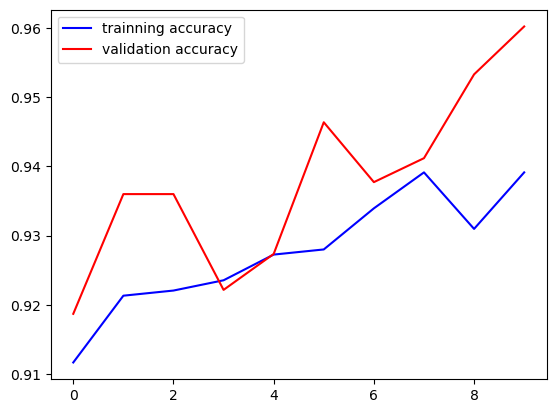

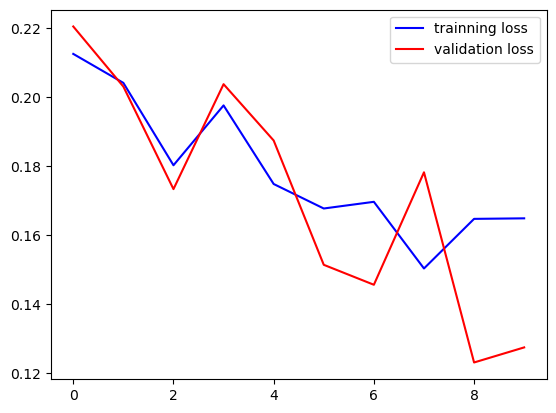

In [58]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

## Save Model

In [84]:
model.save("drowiness_new7.h5")

# Prediction

In [85]:
prediction = np.argmax(model.predict(X_test), axis=-1)

19/19 [==============================] - 19s 977ms/step


In [86]:
prediction

array([3, 3, 2, 3, 1, 3, 3, 2, 1, 2, 3, 3, 3, 2, 2, 2, 3, 2, 0, 3, 3, 3,
       2, 1, 3, 2, 2, 2, 2, 2, 3, 2, 3, 2, 1, 3, 3, 2, 1, 3, 3, 3, 2, 3,
       2, 2, 3, 3, 2, 3, 3, 3, 2, 1, 3, 3, 2, 2, 2, 0, 3, 3, 1, 3, 2, 3,
       2, 3, 2, 2, 1, 3, 3, 3, 2, 0, 1, 3, 1, 3, 2, 0, 3, 2, 2, 2, 2, 1,
       3, 3, 2, 3, 3, 3, 1, 0, 3, 0, 3, 3, 3, 1, 3, 1, 2, 3, 3, 1, 2, 3,
       1, 1, 2, 1, 0, 3, 3, 3, 2, 2, 3, 3, 2, 0, 1, 2, 3, 3, 2, 0, 3, 2,
       0, 3, 1, 2, 3, 3, 2, 1, 2, 2, 2, 1, 3, 3, 2, 3, 2, 0, 2, 3, 3, 3,
       3, 1, 1, 0, 3, 1, 3, 2, 2, 3, 2, 3, 3, 2, 3, 2, 3, 1, 2, 0, 3, 3,
       2, 2, 0, 2, 3, 0, 2, 1, 3, 2, 3, 1, 2, 0, 1, 3, 2, 2, 2, 2, 2, 0,
       3, 2, 3, 0, 2, 0, 0, 1, 2, 3, 2, 0, 3, 1, 2, 2, 2, 2, 1, 3, 1, 1,
       1, 2, 2, 3, 3, 3, 3, 0, 1, 2, 1, 0, 3, 3, 1, 3, 3, 1, 3, 3, 0, 1,
       0, 0, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 2, 0, 2, 2, 2, 1, 3, 3, 2, 2,
       3, 2, 2, 0, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 0, 1, 0, 3, 3, 3, 3, 2,
       2, 1, 2, 2, 2, 3, 2, 0, 2, 2, 1, 3, 2, 3, 1,

# classification report

In [87]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [88]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), prediction, target_names=labels_new))

              precision    recall  f1-score   support

        yawn       0.92      0.75      0.82        63
     no_yawn       0.85      0.92      0.88        74
      Closed       0.92      0.96      0.94       215
        Open       0.95      0.94      0.94       226

    accuracy                           0.92       578
   macro avg       0.91      0.89      0.90       578
weighted avg       0.92      0.92      0.92       578



# predicting function

eyes not detected
eyes not detected


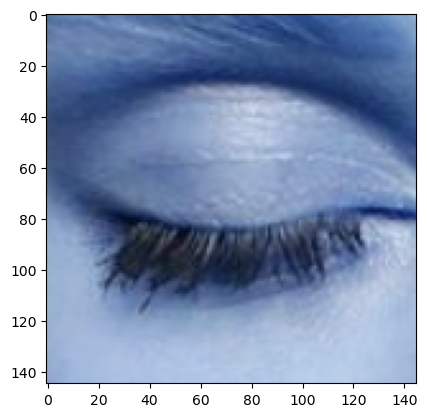

In [293]:
# labels_new = ["yawn", "no_yawn", "Closed", "Open"]

img = cv2.imread("close9.jpg")

eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

eyes = eye_cascade.detectMultiScale(gray, 1.4, 1)



IMG_SIZE = 145

# def prepare(filepath):
for x,y,w,h in eyes:
    
#     img = cv2.imread(filepath)
    
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    if len(eyes) == 0:
        print("eyes not detected")
        
    else:
        for(ex,ey,ew,eh) in eyes:
            eyes_roi = roi_color[ey: ey+eh, ex:ex + ew]
        
        
# plt.imshow(cv2.cvtColor(eyes_roi, cv2.COLOR_BGR2RGB))    
    
img_array = cv2.resize(eyes_roi, (IMG_SIZE, IMG_SIZE))  
img_array = img_array / 255

image = img_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)  

# plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))  

plt.imshow(img_array)
img_array.shape


#     resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    
# image = resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    

#     return image


model = tf.keras.models.load_model("drowiness_new7.h5")

In [294]:
img_array.shape

(145, 145, 3)

In [295]:
prediction = model.predict(image)

1/1 [==============================] - 0s 198ms/step


In [296]:
prediction
np.argmax(prediction)

2